In [8]:
import os

os.chdir(os.path.join(os.getcwd(), '/home/mhill/Projects/cathepsin/'))  # '.' if the path is to current folder
print(os.getcwd())



/home/mhill/Projects/cathepsin


In [9]:

from src.unetr_8x8 import CustomUNETR8
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from transformers import ViTModel, ViTConfig

from logs.unetr.view_out import plot_loss, report_metrics, segment
from src.utils import select_device
from src.datasets import UnetCustomDataset, unet_valid_collate


Change Config Based on model


In [10]:
device = select_device()
vitconfig = {  # <- change
    "attention_probs_dropout_prob": 0.0,
    "encoder_stride": 8,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 192,
    "image_size": 64,
    "initializer_range": 0.02,
    "intermediate_size": 768,
    "layer_norm_eps": 1e-06,
    "model_type": "vit",
    "num_attention_heads": 6,
    "num_channels": 16,
    "num_hidden_layers": 6,
    "patch_size": 8,
    "qkv_bias": True,
    "transformers_version": "4.42.3"
}

unet_config = {  # <- change
    'BATCH_SIZE': 32,
    'BETA_1': 0.9,
    'BETA_2': 0.95,
    'COMMENT': 'Run 12: Patch 12 w/augmented data 100 epochs, 32 feature size',
    'FEATURE_SIZE': 32,
    'IN_CHANNEL': 16,
    'LEARNING_RATE': 1e-05,
    'LOG_DIR': 'logs/unetr/12/',
    'NUM_CLASSES': 16,
    'NUM_EPOCHS': 100,
    'PRE_TRAINED_MODEL': '/home/mhill/Projects/cathepsin/logs/vitmae/17/model.pth',
    'RANDOM_SEED': 42,
    'RES_BLOCK': True,
    'SAVE_MODELS': 1,
    'SPATIAL_DIMS': 2,
    'TEST_DATASET': '/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz',
    'TRAIN_DATASET': '/home/mhill/Projects/cathepsin/data/unet_training_dataset.npz',
    'VALID_DATASET': '/home/mhill/Projects/cathepsin/data/unet_validation_dataset.npz',
    'WEIGHT_DECAY': 0.0
}

MODEL_PATH = "/home/mhill/Projects/cathepsin/logs/unetr/13/model.pth"  # <- change
checkpoint = torch.load(MODEL_PATH, map_location=device)

encoder = ViTModel(config=ViTConfig(**vitconfig)).to(device)

model = CustomUNETR8(encoder=encoder, feature_size=unet_config["FEATURE_SIZE"],
                     num_classes=unet_config["NUM_CLASSES"]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Loading Test Data

In [11]:
test_data = np.load("/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz")
test_images, test_labels = test_data['images'], test_data['labels']
test_dataset = UnetCustomDataset(test_images, test_labels)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=unet_valid_collate
)

Train Loss 

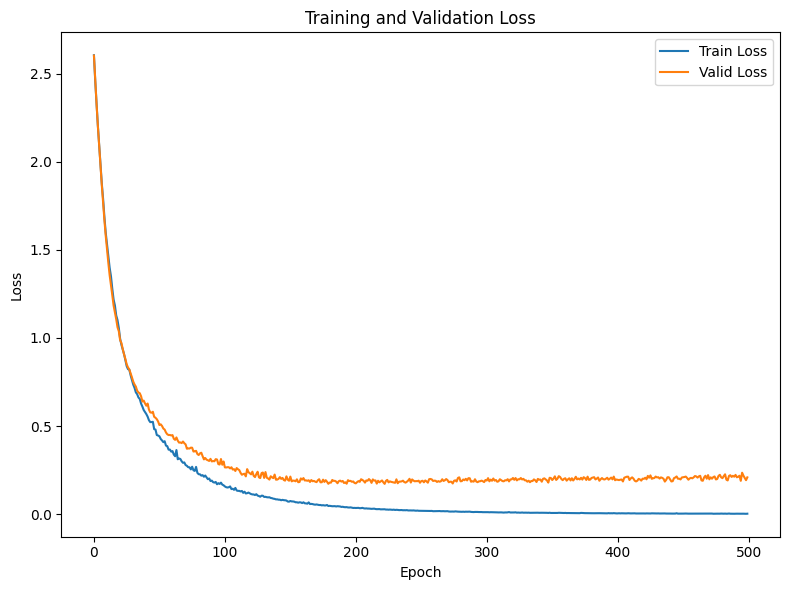

In [12]:
df_train = pd.read_csv("/home/mhill/Projects/cathepsin/logs/unetr/13/training_results.csv")  # <- change
plot_loss(df_train)

In [13]:
report_metrics(model=model, test_dataloader=test_dataloader)

Test Loss : 0.18416056423506477
 Class Report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      6960
           1       0.94      0.87      0.91       940
           2       0.54      0.78      0.63       135
           3       0.95      0.91      0.93       737
           5       0.86      0.76      0.81       155
           6       0.96      0.82      0.89        62
           7       0.00      0.00      0.00         0
           8       0.57      0.94      0.71       131
           9       0.67      0.52      0.58       132
          10       0.99      0.99      0.99      6360
          11       1.00      1.00      1.00      3211

    accuracy                           0.97     18823
   macro avg       0.77      0.78      0.77     18823
weighted avg       0.97      0.97      0.97     18823

Val loss: 0.18416056523263205


Shape of image_np : (16, 16, 64, 64) | Label_np : (16, 64, 64) | Predictions : (16, 64, 64)


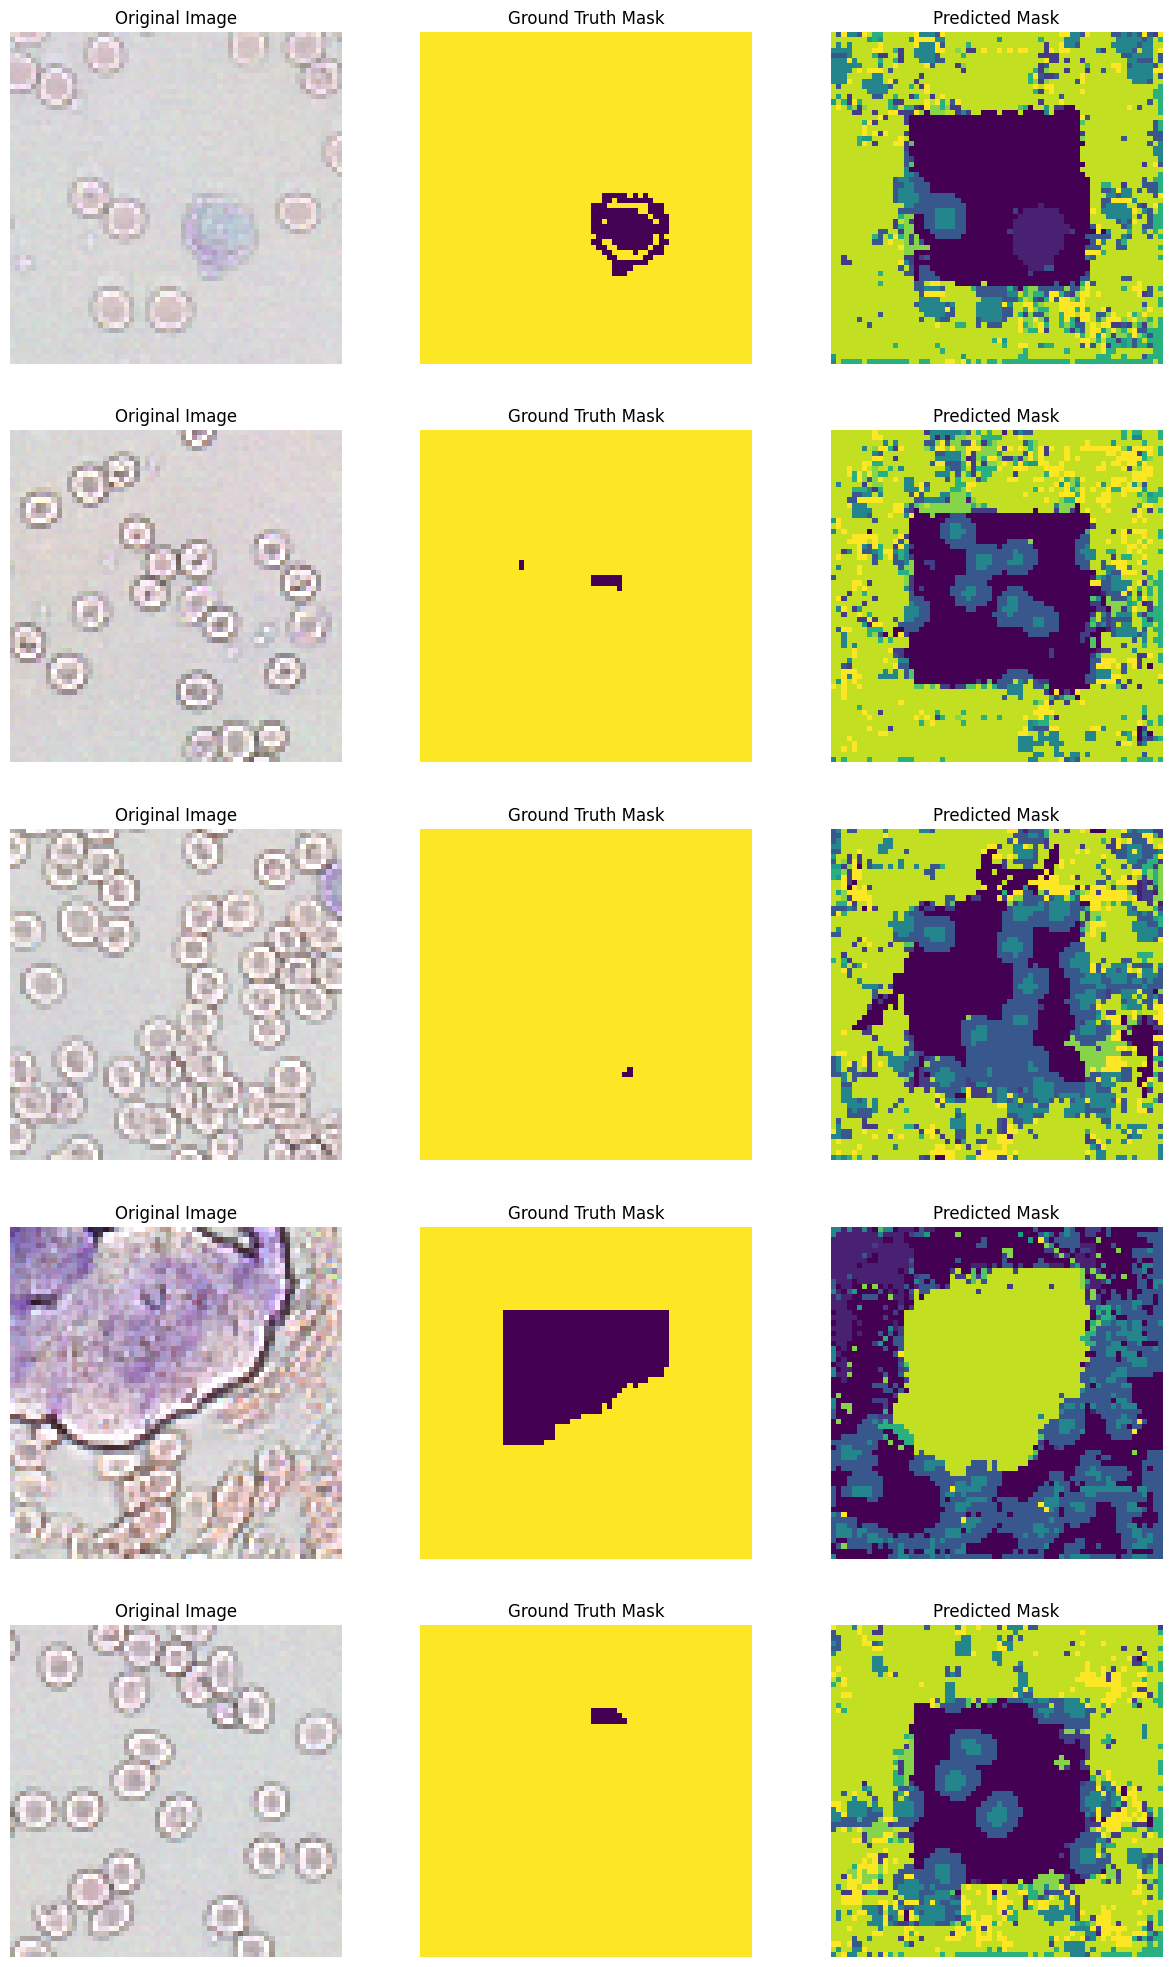

In [14]:
segment(model=model, test_dataloader=test_dataloader)